# Table of Contents
* [Loading data](#Loading-data)
* [Looking at objects](#Looking-at-objects)
* [Looking at scenes](#Looking-at-scenes)
* [Looking at image complexity](#Looking-at-image-complexity)
* [Defining question object categories](#Defining-question-object-categories)
* [Displaying random image and questions](#Displaying-random-image-and-questions)
* [Extacting bounding boxes from segmentation mask](#Extacting-bounding-boxes-from-segmentation-mask)
* [Build dataset scaffolding](#Build-dataset-scaffolding)
* [Test new bbox approach](#Test-new-bbox-approach)
* [hide](#hide)


In [1]:
%%capture
from __future__ import division
import numpy as np
import pandas as pd
import scipy.stats as st
import itertools
import math
from collections import Counter, defaultdict
%load_ext autoreload
%autoreload 2

In [2]:
%%capture
import matplotlib as mpl
mpl.use("Agg")
import matplotlib.pylab as plt
#%matplotlib notebook
%matplotlib inline
%load_ext base16_mplrc
%base16_mplrc light solarized
# %base16_mplrc dark solarized
plt.rcParams['grid.linewidth'] = 0
plt.rcParams['figure.figsize'] = (16.0, 10.0)

In [3]:
import os
import itertools
import random
import cv2
import scipy.io as sio
import PIL.Image as Image

In [4]:
import pqa_utils.ade_extractor as ade_ext

# Loading data

## ADE

In [11]:
ade_matdata = sio.loadmat('../ade20k/ADE20K_2016_07_26/index_ade20k.mat',  struct_as_record=False, squeeze_me=True)
ade_index = ade_matdata['index']

In [12]:
ade_index._fieldnames

['filename',
 'folder',
 'typeset',
 'objectIsPart',
 'objectPresence',
 'objectcounts',
 'objectnames',
 'proportionClassIsPart',
 'scene',
 'wordnet_found',
 'wordnet_level1',
 'wordnet_synset',
 'wordnet_hypernym',
 'wordnet_gloss',
 'wordnet_synonyms',
 'wordnet_frequency']

In [13]:
image_df = pd.DataFrame([ade_index.filename, ade_index.folder, ade_index.scene]).T
image_df.columns = ['filename', 'folder', 'scene']

In [14]:
obj_df = pd.DataFrame([ade_index.objectnames, ade_index.objectcounts, ade_index.proportionClassIsPart, ade_index.wordnet_found, ade_index.wordnet_level1, 
                       ade_index.wordnet_synset, ade_index.wordnet_hypernym, ade_index.wordnet_gloss, ade_index.wordnet_synonyms, ade_index.wordnet_frequency]).T
obj_df.columns = ['objectnames', 'objectcounts', 'proportionClassIsPart', 'wordnet_found',
 'wordnet_level1',
 'wordnet_synset',
 'wordnet_hypernym',
 'wordnet_gloss',
 'wordnet_synonyms',
 'wordnet_frequency']

img_obj_df = pd.DataFrame(ade_index.objectPresence).T
img_obj_df.index = image_df['filename']
img_obj_df.columns = obj_df['objectnames']

## Volume est.

In [111]:
v_data_train_file = '../volume_est_dataset/data_trainval.txt'

In [112]:
vol_est_df.head(2)

,0,1,2,3,4,5,6,7,8,9
0,00225.png,glass,90,207,188,349,100,3,1,2
1,01238.png,bottle,128,280,161,370,30,1,4,2


In [131]:
vol_est_df_raw = pd.read_csv(v_data_train_file, sep=' ', header=None)

In [150]:
vol_est_df_raw['rectangle'] = vol_est_df_raw.iloc[:, 2:6].T.apply(lambda x: ' '.join(x.astype(str)))
vol_est_df = pd.concat([vol_est_df_raw.iloc[:, 0:2], vol_est_df_raw.iloc[:, 6:]], axis=1)
vol_est_df.columns = ['image_name', 'obj_name', 'volume', 'vol_bin', 'ns', 'is_occulted', 'rectangle']
vol_est_df['rectangle'] = vol_est_df['rectangle'].apply(lambda x: x.split())

In [160]:
vol_est_df.iloc[:, :-1].apply(lambda x: len(pd.unique(x)))

image_name     5193
obj_name         12
volume          343
vol_bin          11
ns                6
is_occulted       3
dtype: int64

# Looking at objects

In [15]:
common_objects_df = obj_df[obj_df['objectcounts'] > 50]

In [16]:
common_objects_df['objectnames'].shape

(495,)

In [17]:
# _ = obj_df[obj_df['wordnet_frequency'] < 6000]['wordnet_frequency'].hist(bins = 60, log=True)

In [18]:
primary_obj_df = common_objects_df[common_objects_df['proportionClassIsPart'] == 0]

In [19]:
primary_obj_df['objectcounts'].sum() / obj_df['objectcounts'].sum()

0.4506219

In [20]:
primary_obj_df.shape

(305, 10)

In [21]:
short_names = {}
for name in primary_obj_df['objectnames']:
    split_names = name.split(',')
    for nc in split_names:
        if nc not in short_names.values():
            short_names[name] = nc.strip()
            break

In [23]:
len(short_names)

305

In [25]:
invert_short_names = {v:k for k,v in short_names.items()}

In [26]:
invert_short_names['tank']

'tank, storage tank'

In [29]:
%%capture
primary_obj_df['shortname'] = primary_obj_df['objectnames'].apply(lambda x: short_names[x])

In [30]:
# object_annotation_blank = pd.DataFrame(np.hstack((primary_obj_df['shortname'].values.reshape(primary_obj_df.shape[0], 1), np.zeros((primary_obj_df.shape[0], 5)))))
# object_annotation_blank.columns = ['shortname', 'metric', 'movable', 'set_on', 'container', 'liquid']

In [31]:
# object_annotation_blank.to_csv('object_annotaions.csv', index=False)

In [32]:
object_properties = pd.read_csv('../ade20k/object_annotations.csv')

# Looking at scenes

In [33]:
coarse_scenes = set([sce.split('/')[0] for sce in ade_index.scene.tolist()])

In [34]:
indoor_words = ['indoor', 'interior', 'home', 'shop', 'office', 'hall', 'store']
outdoor_words = ['outdoor', 'exterior', 'forest', 'street', 'deck', 'garden', 'house', 'park', 'field', 'arena', 'farm', 'bridge']

scenes_by_type = defaultdict(set)
for scene in ade_index.scene.tolist():
    if set(indoor_words).intersection(set([item for sublist in [sc.split('_') for sc in scene.split('/')] for item in sublist])) or 'room' in scene:
        scenes_by_type['indoor'].add(scene)
    elif set(outdoor_words).intersection(set([item for sublist in [sc.split('_') for sc in scene.split('/')] for item in sublist])):
        scenes_by_type['outdoor'].add(scene)
    else:
        scenes_by_type['ambiguous'].add(scene)

In [35]:
for k, v in scenes_by_type.items():
    print(k, len(v))

indoor 226
ambiguous 469
outdoor 177


In [36]:
scene_assignments = {}
for stype, scene_cats in scenes_by_type.items():
    for scene_cat in scene_cats:
        scene_assignments[scene_cat] = stype

In [37]:
image_df['setting'] = image_df['scene'].apply(lambda x: scene_assignments[x])

In [38]:
in_out_counts = defaultdict(int)
for scene in ade_index.scene.tolist():
    in_out_counts[scene_assignments[scene]] += 1

In [39]:
in_out_counts

defaultdict(int, {'ambiguous': 10805, 'indoor': 7028, 'outdoor': 4377})

In [40]:
word_pieces = []
for scene in scenes_by_type['ambiguous']:
    word_pieces.extend([item for sublist in [sc.split('_') for sc in scene.split('/')] for item in sublist])

# Looking at image complexity

In [41]:
obj_counts = img_obj_df.sum(axis=1)

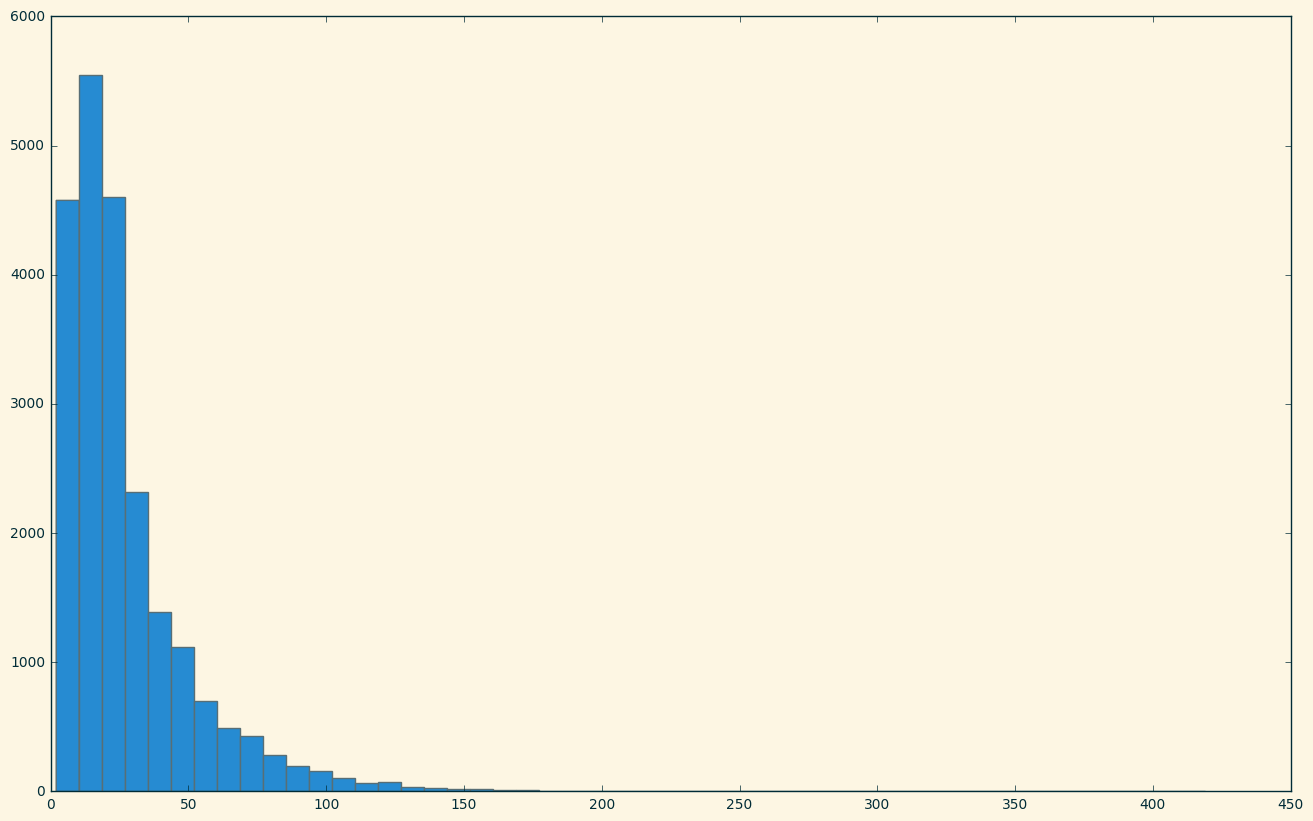

In [42]:
_ = obj_counts.hist(bins=50)

# Defining question object categories

In [43]:
q_cat_defs = {
    'vol_cats': ['glass, drinking glass', 'mug', 'bowl', 'bottle', 'box', 'bucket, pail', 'can, tin, tin can', 'container', 'jar'],
    'openable_cats': ['chest of drawers, chest, bureau, dresser', 'cabinet'],
    'surface_cats': ['coffee table, cocktail table', 'bench', 'counter', 'countertop', 'shelf', 'table']
    }

In [44]:
tot_objs = obj_df['objectcounts'].sum()

In [45]:
image_obj_dict = img_obj_df.to_dict(orient='index')

In [46]:
primary_objs = set(primary_obj_df['shortname'].tolist())

In [47]:
# object_properties.index = object_properties['shortname']
# del object_properties['shortname']

In [76]:
object_properties.index = object_properties['shortname']

In [77]:
obj_prop_lookup = defaultdict(list)
for ob_name, objs in object_properties.to_dict(orient='index').items():
    for prop_type, sel in objs.items():
        if sel:
            obj_prop_lookup[ob_name].append(prop_type)

In [80]:
image_obj_cat_counts = defaultdict(lambda: defaultdict(int))
for img_n, objs in image_obj_dict.items():
    for obj, count in objs.items():
        if not count:
            continue
        elif obj in primary_objs:
            obj_props = obj_prop_lookup[obj]
            for prop in obj_props:
                image_obj_cat_counts[img_n][prop] += count

In [81]:
from math import factorial
def n_choose_2(n):
    if n < 2:
        return 0
    else:
        return factorial(n) / (2 * factorial(n - 2))

In [59]:
len(image_obj_dict)

22210

In [82]:
question_expectations = defaultdict(int)

for img_n, type_counts in image_obj_cat_counts.items():
    if 'metric' in type_counts:
        question_expectations['geometry_metric'] += n_choose_2(type_counts['metric'])
    if 'movable' in type_counts:
        question_expectations['movable'] += type_counts['movable']
    if 'set_on' in type_counts:
        question_expectations['set_on'] += type_counts['set_on']
    if 'container' in type_counts:
        question_expectations['container'] += n_choose_2(type_counts['metric'])
    if 'liquid' in type_counts:
        question_expectations['liquid'] += type_counts['liquid'] 

In [85]:
q_est_df = pd.DataFrame(question_expectations, index=[0]).T
q_est_df.columns = ['raw_estimate']
q_est_df['scaled'] = q_est_df['raw_estimate']

q_est_df['scaled'] = q_est_df['scaled']

q_est_df.filter(like='geo', axis=0)['scaled'] = q_est_df.filter(like='geo', axis=0)['scaled'] * 0.1

q_est_df.ix[q_est_df.index=='geometry_metric', 'scaled'] = q_est_df.ix[q_est_df.index=='geometry_metric', 'scaled'] / 100
q_est_df.ix[q_est_df.index=='container', 'scaled'] = q_est_df.ix[q_est_df.index=='container', 'scaled'] / 100

In [86]:
q_est_df

,raw_estimate,scaled
container,197486.0,1974.86
geometry_metric,384769.0,3847.69
liquid,1200.0,1200.00
movable,44740.0,44740.00
set_on,23351.0,23351.00


# Displaying random image and questions

In [39]:
def scene_selection_filter(scene):
    return

In [40]:
def object_selection_filter(image_name):
    conditions_met = False
    return conditions_met

In [41]:
def get_ade_image(image_df, ade_pre = '.', setting=None, obj_categories=None):
    global img_n
    found = False
    while not found:
        img_row_to_load = np.random.randint(0, image_df.shape[0])
        img_n = img_row_to_load
        image_path = os.path.join(ade_pre, image_df.iloc[img_row_to_load]['folder'], image_df.iloc[img_row_to_load]['filename'])
        mask_path = os.path.join(ade_pre, image_df.iloc[img_row_to_load]['folder'], image_df.iloc[img_row_to_load]['filename'].replace('.jpg', '_seg.png')) 
        img_to_disp = Image.open(image_path)
        mask = Image.open(mask_path)
        if not setting:
            found = 'True'
        elif image_df.iloc[img_row_to_load]['setting'] == setting:
            found = 'True'
        else:
            pass
    return img_to_disp, mask

In [43]:
# raw_image, mask_p1 = get_ade_image(image_df, setting='indoor')

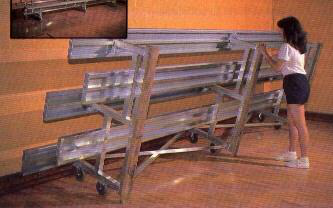

In [78]:
raw_image

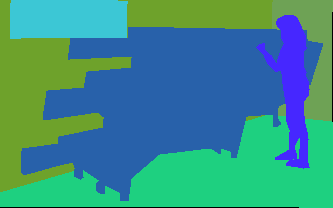

In [79]:
mask_p1

In [80]:
mask_array = np.array(list(mask_p1.getdata()))

In [82]:
test_image_df = img_obj_df.iloc[img_n][img_obj_df.iloc[img_n] != 0]

In [83]:
test_image_df

objectnames
floor, flooring                                        1.0
grandstand, covered stand                              1.0
painting, picture                                      1.0
person, individual, someone, somebody, mortal, soul    1.0
wall                                                   2.0
Name: ADE_train_00004314.jpg, dtype: float32

In [84]:
test_image_objects = img_obj_df.iloc[img_n][img_obj_df.iloc[img_n] != 0].index.tolist()
pruned_test_image_objects = [ob.split(',')[0] for ob in test_image_objects]
object_combos = list(itertools.combinations(pruned_test_image_objects, 2))

for objcts in random.sample(object_combos, 5):
    print('How far is the {} from the {}?'.format(*objcts))

How far is the floor from the wall?
How far is the painting from the person?
How far is the grandstand from the painting?
How far is the person from the wall?
How far is the grandstand from the person?


# Extacting bounding boxes from segmentation mask

In [4]:
test_image_path = '/Users/schwenk/wrk/pqa/ade20k/ADE20K_2016_07_26/images/training/c/computer_room/'
test_image = Image.open(test_image_path + 'ADE_train_00005940.jpg')
test_mask = Image.open(test_image_path + 'ADE_train_00005940_seg.png')
cv_mask = cv2.imread(test_image_path + 'ADE_train_00005940_seg.png')

In [47]:
# Image.fromarray(cv_mask[::,::,::-1])

In [48]:
# pd.value_counts(r_chan.flatten())
# pd.value_counts(g_chan.flatten())
# pd.value_counts(b_chan.flatten())

In [41]:
obj_df['obj_class'] = obj_df.index + 1

In [90]:
split_cols = obj_df[['obj_class', 'objectnames']].to_dict(orient='split')
ob_name_lookup = {pair[0]: pair[1] for pair in split_cols['data']}

In [43]:
sorted(pd.Series(b_chan.flatten()).value_counts().index.tolist())

NameError: name 'b_chan' is not defined

In [44]:
len(sorted(pd.Series(b_chan.flatten()).value_counts().index.tolist()))

NameError: name 'b_chan' is not defined

# Build dataset scaffolding

In [587]:
def extract_objs_bboxes(label_array, image_name):
    obj_mask = label_array[::,::,0:1].reshape(label_array.shape[:2])
    g_chan = label_array[::,::,1:2]
    r_chan = label_array[::,::,2:3]
    class_mask = r_chan.astype(int) / 10 * 256  +  g_chan.astype(int)
    class_mask = class_mask.astype(int)

    detections = defaultdict(dict)
    mask_iter = np.nditer(obj_mask, flags=['multi_index'])
    while not mask_iter.finished:
        pix_val = mask_iter[0].item()
        x_coord, y_coord = mask_iter.multi_index[:2]
        if pix_val not in detections:
            class_assigment = class_mask[x_coord][y_coord].item()
            if class_assigment:
                detections[pix_val]['classID'] = class_assigment
                detections[pix_val]['classDescription'] = ob_name_lookup[detections[pix_val]['classID']]
                detections[pix_val]['rectangle'] = [x_coord, y_coord] * 2
                detections[pix_val]['globalID'] = '_'.join([image_name, str(pix_val)])
        else:
            x_min, y_min, x_max, y_max = detections[pix_val]['rectangle']
            if x_coord > x_min:
                detections[pix_val]['rectangle'][0] = x_coord
            if x_coord < x_max:
                detections[pix_val]['rectangle'][1] = x_coord
            if y_coord > y_min:
                detections[pix_val]['rectangle'][2] = y_coord
            if y_coord < y_max:
                detections[pix_val]['rectangle'][3] = y_coord
        mask_iter.iternext()
    return detections

def build_dataset():
    return

def build_object_entry(image_name, image_path, img_obj_df):
    img_seg_name = image_name.replace('.jpg', '_seg.png')
    pixel_array = cv2.imread(os.path.join(image_path, img_seg_name))
    objects = extract_objs_bboxes(pixel_array, image_name)
    return objects

def build_image_entry(image_df_row, dpp):
    image_fields = {}
    image_name = image_df_row['filename']
    image_path = '../ade20k/' + image_df_row['folder']
    image_fields['imageName'] = image_name
    image_fields['imageName'] = image_name
    image_fields['scene'] = image_df_row['scene']
    image_fields['setting'] = image_df_row['setting']
    image_fields['objects'] = build_object_entry(image_name, image_path, img_obj_df)
    dpp[image_name] = image_fields

def call_apply_fn(df): 
    ds_p = {}
    build_image_entry_part = functools.partial(build_image_entry)
    df.apply((lambda x: build_image_entry_part(x, ds_p)), axis=1)
    return ds_p

In [193]:
from multiprocessing import Pool
import functools

In [589]:
%%time
n_processes = 8
pool = Pool(processes=n_processes)

df = image_df.head(100)
df_split = np.array_split(df, n_processes)
pool_results = pool.map(call_apply_fn, df_split)
combined_results = {}
for res in pool_results:
    combined_results.update(res)

CPU times: user 747 ms, sys: 1.19 s, total: 1.94 s
Wall time: 1min 23s


In [416]:
image_df.shape[0] / 100 / 60

3.7016666666666667

In [65]:
trr = list(combined_results.values())[40]

NameError: name 'combined_results' is not defined

In [591]:
trr['imageName']

'ADE_train_00000075.jpg'

In [592]:
trr.keys()

dict_keys(['imageName', 'setting', 'objects', 'scene'])

In [63]:
flat_image_dir = '/Users/schwenk/wrk/pqa/ade20k/ADE20K_2016_07_26/images/training/flattened/'

In [602]:
# 180: {'classDescription': 'stool',
#               'classID': 2586,
#               'globalID': 'ADE_train_00000075.jpg_180',
#               'rectangle': [1088, 1398, 459, 487]}

In [46]:
label_array = cv_mask
obj_mask = label_array[::,::,0:1].reshape(label_array.shape[:2])
g_chan = label_array[::,::,1:2]
r_chan = label_array[::,::,2:3]
class_mask = r_chan.astype(int) / 10 * 256  +  g_chan.astype(int)
class_mask = class_mask.astype(int)

In [47]:
np.unique(obj_mask.flatten())

array([  0,   6,  12,  17,  23,  29,  35,  41,  46,  52,  58,  64,  70,
        75,  81,  87,  93,  99, 104, 110, 116, 122, 128, 133, 139, 145,
       151, 156, 162, 168, 174, 180, 185, 191, 197, 203, 209, 214, 220,
       226, 232, 238, 243, 249, 255], dtype=uint8)

In [48]:
obj1 = obj_mask == 6

In [64]:
cv_tarr = cv2.imread(flat_image_dir + trr['imageName'])

NameError: name 'trr' is not defined

In [582]:
cv_tarr.shape

(1400, 1772, 3)

In [545]:
# %time image_df.head(10).apply(lambda x: build_image_entry(x, dpp), axis = 1)

In [ ]:
test_name = 'ADE_train_00005940.jpg'

In [45]:
cv_mask = cv2.imread(test_image_path + 'ADE_train_00005940_seg.png')

In [223]:
timg= 'ADE_train_00005940.jpg'
build_image_entry(timg, image_df)

{'imageName': 'ADE_train_00005940.jpg',
 'objects': {},
 'scene': 'computer_room',
 'setting': 'indoor'}

In [216]:
image_df[image_df['filename'] == timg]['scene']

5939    computer_room
Name: scene, dtype: object

In [273]:
primary_objs = set(primary_obj_df['shortname'].tolist())

In [278]:
primary_obj_df['obj_class']  = primary_obj_df.index + 1

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


5                    ad
9       air conditioner
13             airplane
28               animal
31              antenna
37              apparel
46       arcade machine
48               arcade
51                 arch
56             armchair
63               ashcan
64              ashtray
76               awning
78           baby buggy
89             backpack
95                  bag
96        traveling bag
102                ball
107             balloon
112              bamboo
117              banner
119           bannister
122                 bar
130              barrel
136                base
140           baseboard
144              basket
145          handbasket
154             bathtub
159              beacon
             ...       
2781            toaster
2791      toilet tissue
2792             toilet
2820              towel
2823         towel rack
2832         trade name
2833       traffic cone
2835      traffic light
2839              train
2876            trouser
2879            

In [215]:
obj_df[obj_df['obj_class'] == sample_n]

,objectnames,objectcounts,proportionClassIsPart,wordnet_found,wordnet_level1,wordnet_synset,wordnet_hypernym,wordnet_gloss,wordnet_synonyms,wordnet_frequency,obj_class
2981,"wall socket, wall plug, electric outlet, elect...",1633,0,1,"wall socket, wall plug, electric outlet, elect...","wall socket, wall plug, electric outlet, elect...","[wall socket, wall plug, electric outlet, elec...",receptacle providing a place in a wiring syste...,"wall socket, wall plug, electric outlet, elect...",1,2982


In [283]:
split_cols = primary_obj_df[['obj_class', 'shortname']].to_dict(orient='split')
ob_name_lookup = {pair[0]: pair[1] for pair in split_cols['data']}

In [ ]:
split_cols = obj_df[['obj_class', 'objectnames']].to_dict(orient='split')
ob_name_lookup = {pair[0]: pair[1] for pair in split_cols['data']}

In [285]:
import pickle
with open('ob_name_lookup.pkl', 'wb') as f:
    pickle.dump(ob_name_lookup, f)

# Test new bbox approach

In [443]:
%%time
n_processes = 8
pool = Pool(processes=n_processes)

df = image_df.head(1000)
df_split = np.array_split(df, n_processes)
pool_results = pool.map(ade_ext.call_apply_fn, df_split)
combined_results = {}
for res in pool_results:
    combined_results.update(res)

CPU times: user 2.53 s, sys: 3.14 s, total: 5.67 s
Wall time: 3min 56s


In [444]:
4 * 22

88

In [431]:
test_ob_comp = list(combined_results.values())[60]

In [442]:
# ade_ext.draw_obj_sample(test_ob_comp)

In [293]:
object_properties = pd.read_csv('../ade20k/object_annotations.csv')

In [ ]:
labels_cols = object_properties.iloc[:, 1:]

In [543]:
label_assignments = defaultdict(set)
for label_type in object_properties.iloc[:, 1:].columns.tolist():
    label_assignments[label_type].update(object_properties[object_properties[label_type] == 1]['shortname'].tolist())

If the force shown is applied to the armchair, how will it move?


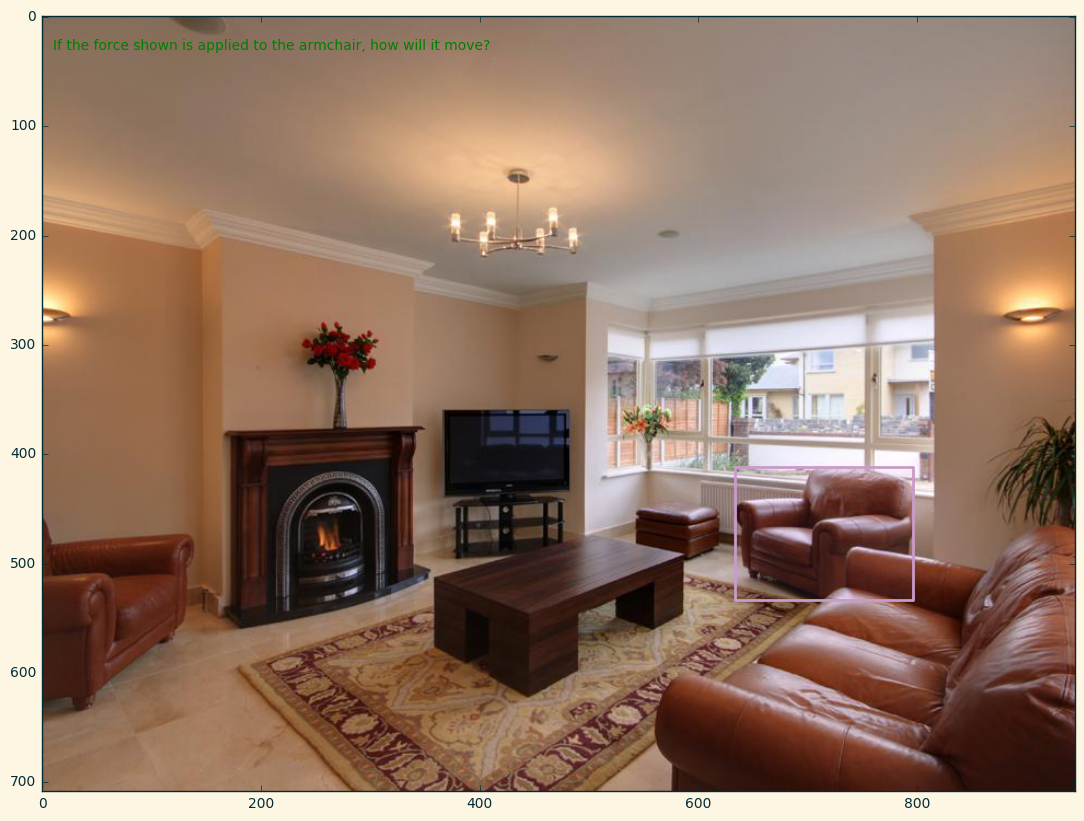

In [552]:
img_index = random.randint(0, len(combined_results))
example_image_anno = list(combined_results.values())[img_index]
image_questions = ade_ext.generate_questions_for_image(example_image_anno, label_assignments)
random_question = np.random.choice(list(image_questions.values()), 1).item()
ade_ext.draw_question(example_image_anno, random_question['gids'], random_question['question_text'])
print(random_question['question_text'])

# Explore synthetic questions

Can the pot fit inside the sink?


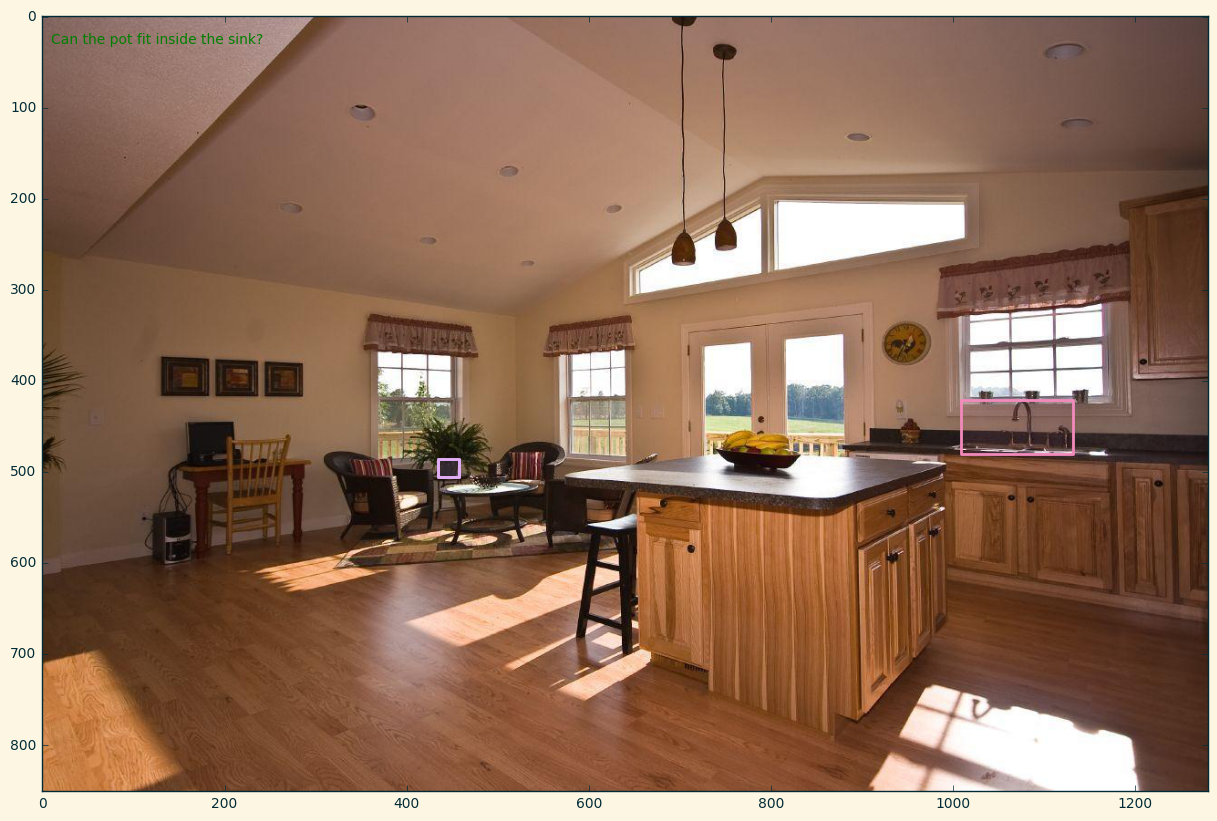

In [511]:
img_index = random.randint(0, len(combined_results))
example_image_anno = list(combined_results.values())[img_index]
image_questions = ade_ext.generate_questions_for_image(example_image_anno, label_assignments)
random_question = np.random.choice(list(image_questions.values()), 1).item()
ade_ext.draw_question(example_image_anno, random_question['gids'], random_question['question_text'])
print(random_question['question_text'])

In [468]:
import json

In [494]:
example_image_anno['objects'] = {'local_id' + str(k):  for k,v in example_image_anno['objects'].items()}

In [500]:
example_image_anno

{'imageName': 'ADE_train_00000750.jpg',
 'objects': {'local_id102': {'classDescription': 'plant',
   'globalID': 'ADE_train_00000750.jpg_102',
   'objectClass': 1910,
   'rectangle': [66, 436, 193, 509],
   'shortName': 'plant'},
  'local_id108': {'classDescription': 'pot',
   'globalID': 'ADE_train_00000750.jpg_108',
   'objectClass': 1981,
   'rectangle': [127, 710, 200, 799],
   'shortName': 'pot'},
  'local_id113': {'classDescription': 'table',
   'globalID': 'ADE_train_00000750.jpg_113',
   'objectClass': 2684,
   'rectangle': [17, 623, 462, 809],
   'shortName': 'table'},
  'local_id119': {'classDescription': 'painting',
   'globalID': 'ADE_train_00000750.jpg_119',
   'objectClass': 1735,
   'rectangle': [123, 2, 236, 355],
   'shortName': 'painting'},
  'local_id125': {'classDescription': 'rug',
   'globalID': 'ADE_train_00000750.jpg_125',
   'objectClass': 2178,
   'rectangle': [511, 630, 871, 808],
   'shortName': 'rug'},
  'local_id130': {'classDescription': 'light',
   'glob

In [506]:
temp_dict = {}
for iv, obv in example_image_anno['objects'].items():
        obv['objectClass'] = str('objectClass')

In [510]:
with open('get.json', 'w') as f:
    json.dump(example_image_anno, f, indent = 3)

# hide

In [ ]:
dynamics_templates = {
    '1_moves_how': 'If the force shown is applied to the {}, how will it move?',
    '1_moves_where': 'If the force shown is applied to the {}, where will it end up?',
    '1_apply_to_move': 'If we want the {} to end up in the region shown, how should we apply a force?'
}

statics_templates = {
    '2_hypo_removal': '',
    '1_apply_to_tip': '',
    '1_apply_to_fall': ''
}

metrics_templates = {
    '2_dist_between': 'How far is the {} from the {}?',
    '1_farthest_from': 'What is the farthest object from the {}?',
    '1_closest_to': 'What is the closest object to the {}?',
    '3_maximize_seperation': 'Where should the {} be moved such that is equally far from the {} and the {}'
}

volume_templates ={
    '2_can_fit': 'Can the {} fit inside the {}?',
    '1_largest_fit': 'What is the largest object in the scene that will fit inside the {}?',
    '2_how_many_fit': 'How many of the {} could fit inside the {}?'
}

liquid_templates = {
    '2_can_liquid_fit': 'Can the {} hold the liquid contained in the {}?',
    '1_est_volums': 'How much liquid could the {} hold?',
}

In [ ]:
# scene_image = Image.open(flat_image_dir + test_image_name)

plt.imshow(scene_image)
ax = plt.gca()
ax.set_aspect('equal')
ade_ext.draw_obj_sample(ax, test_objs)

In [ ]:
obj_cat = r_chan.tolist()
build_val_list = [item for sublist in obj_cat for item in sublist]

In [256]:
%%time
dpp = {}
ade_ext.build_image_entry(image_df[image_df['filename'] == test_image_name].iloc[0], dpp, ob_name_lookup)

CPU times: user 666 ms, sys: 25.8 ms, total: 692 ms
Wall time: 679 ms


In [ ]:
# pd.Series([sc.split('/')[-1] for sc in ade_index.scene.tolist() if sc.split('/')[0] != sc.split('/')[-1]]).value_counts()

In [ ]:
# for qt, cats in q_cat_defs.items():
#     obj_count = obj_df[obj_df['objectnames'].isin(cats)].sum()[1]
#     print(qt, int(obj_count))